In [ ]:
import quandl
import zipline
import pandas as pd
from zipline.api import record, symbol, order_target_percent, order, order_target
from zipline import run_algorithm
from zipline.finance import commission, slippage
from datetime import datetime
import pytz
from talib import EMA
from six import viewkeys
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
)

from zipline.pipeline import Pipeline
from zipline.pipeline.factors import RSI

# silence warnings
import warnings
#warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext zipline


In [3]:
%zipline --start=2000-1-1 --end=2018-1-1 -b quandl


j:\Anaconda3\envs\quantum\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
j:\Anaconda3\envs\quantum\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-03 21:00:00+00:00,NaN,0.0,NaN,4.462677e-03,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2000-01-04 21:00:00+00:00,0.0,0.0,NaN,8.945269e-03,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2000-01-05 21:00:00+00:00,0.0,0.0,NaN,1.344787e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2000-01-06 21:00:00+00:00,0.0,0.0,NaN,1.797056e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2000-01-07 21:00:00+00:00,0.0,0.0,NaN,2.251343e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2000-01-10 21:00:00+00:00,0.0,0.0,NaN,2.707658e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2000-01-11 21:00:00+00:00,0.0,0.0,NaN,3.166009e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2000-01-12 21:00:00+00:00,0.0,0.0,NaN,3.626405e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2000-01-13 21:00:00+00:00,0.0,0.0,NaN,4.088856e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2000-01-14 21:00:00+00:00,0.0,0.0,NaN,4.553371e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [4]:
def make_pipeline():
    rsi = RSI()
    return Pipeline(
        columns={
            'longs': rsi.top(3),
            'shorts': rsi.bottom(3),
        },
    )

In [5]:
def rebalance(context, data):

    # Pipeline data will be a dataframe with boolean columns named 'longs' and
    # 'shorts'.
    pipeline_data = context.pipeline_data
    all_assets = pipeline_data.index

    longs = all_assets[pipeline_data.longs]
    shorts = all_assets[pipeline_data.shorts]

    record(universe_size=len(all_assets))

    # Build a 2x-leveraged, equal-weight, long-short portfolio.
    one_third = 1.0 / 3.0
    for asset in longs:
        order_target_percent(asset, one_third)

    for asset in shorts:
        order_target_percent(asset, -one_third)

    # Remove any assets that should no longer be in our portfolio.
    portfolio_assets = longs | shorts
    positions = context.portfolio.positions
    for asset in viewkeys(positions) - set(portfolio_assets):
        # This will fail if the asset was removed from our portfolio because it
        # was delisted.
        if data.can_trade(asset):
            order_target_percent(asset, 0)


In [6]:
def initialize(context):
    attach_pipeline(make_pipeline(), 'my_pipeline')

    # Rebalance each day.  In daily mode, this is equivalent to putting
    # `rebalance` in our handle_data, but in minute mode, it's equivalent to
    # running at the start of the day each day.
    schedule_function(rebalance, date_rules.every_day())

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    context.pipeline_data = pipeline_output('my_pipeline')

In [7]:
def _test_args():
    """
    Extra arguments to use when zipline's automated tests run this example.
    Notes for testers:
    Gross leverage should be roughly 2.0 on every day except the first.
    Net leverage should be roughly 2.0 on every day except the first.
    Longs Count should always be 3 after the first day.
    Shorts Count should be 3 after the first day, except on 2013-10-30, when it
    dips to 2 for a day because DELL is delisted.
    """
    import pandas as pd

    return {
        # We run through october of 2013 because DELL is in the test data and
        # it went private on 2013-10-29.
        'start': pd.Timestamp('2013-10-07', tz='utc'),
        'end': pd.Timestamp('2013-11-30', tz='utc'),
        'capital_base': 100000,
    }


In [12]:
import matplotlib.pyplot as plt
# Set up the stuff for running the trading simulation
base_capital = 500000
start = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc)
# run the trading algorithm and save the results in perf
perf = run_algorithm(start, end, initialize, base_capital, before_trading_start=before_trading_start, bundle = 'quandl')

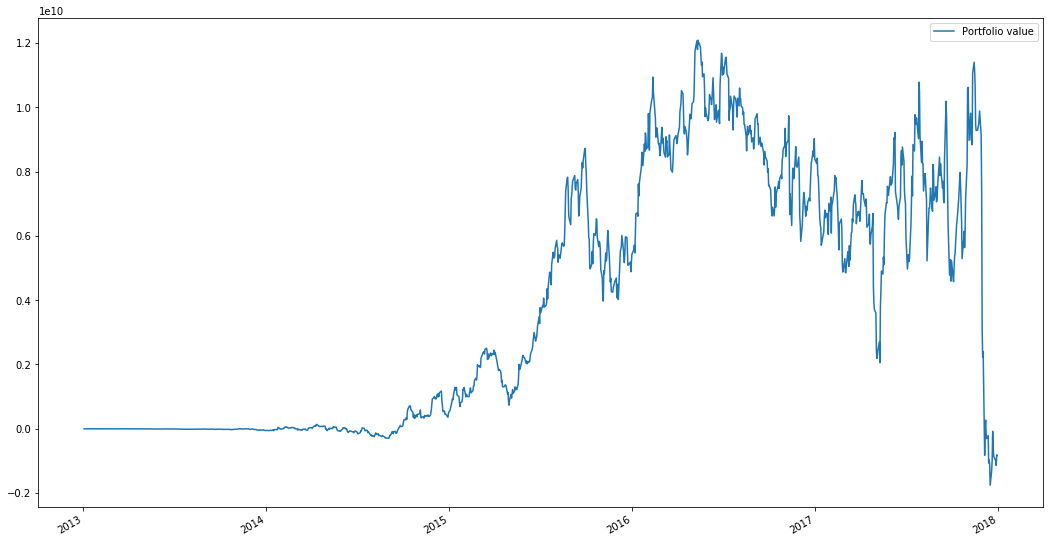

In [13]:
# Draw a nice plot of the value of our portfolio and save it
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
perf.portfolio_value.plot(label="Portfolio value")
# This is was generated by the run_algorithm
plt.legend()
plt.savefig('returns_appl2.png')


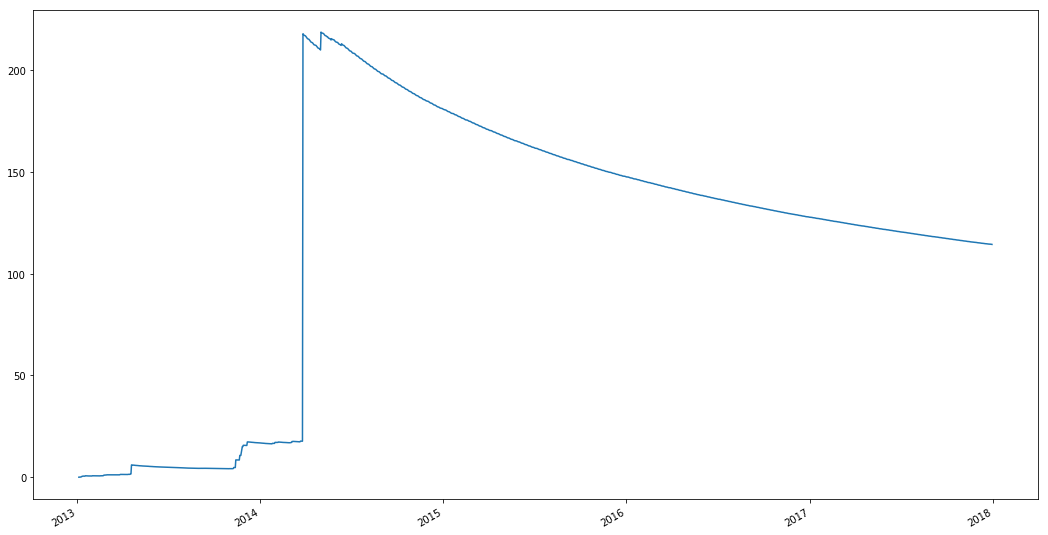

In [14]:
plt.figure(figsize=(18,10))
perf.algo_volatility.plot(label="Volatility")

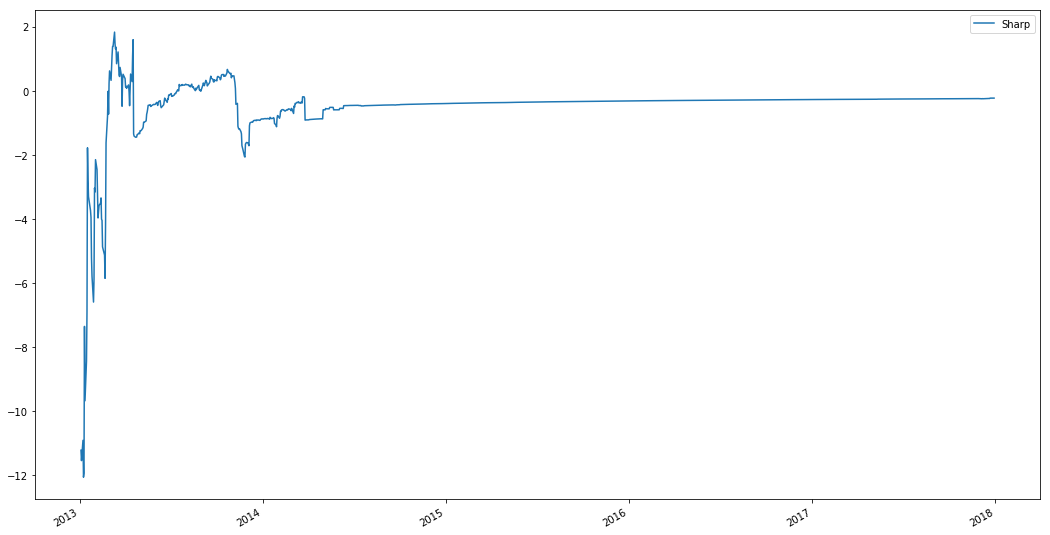

In [15]:
plt.figure(figsize=(18,10))
perf.sharpe.plot(label="Sharp")
plt.legend()

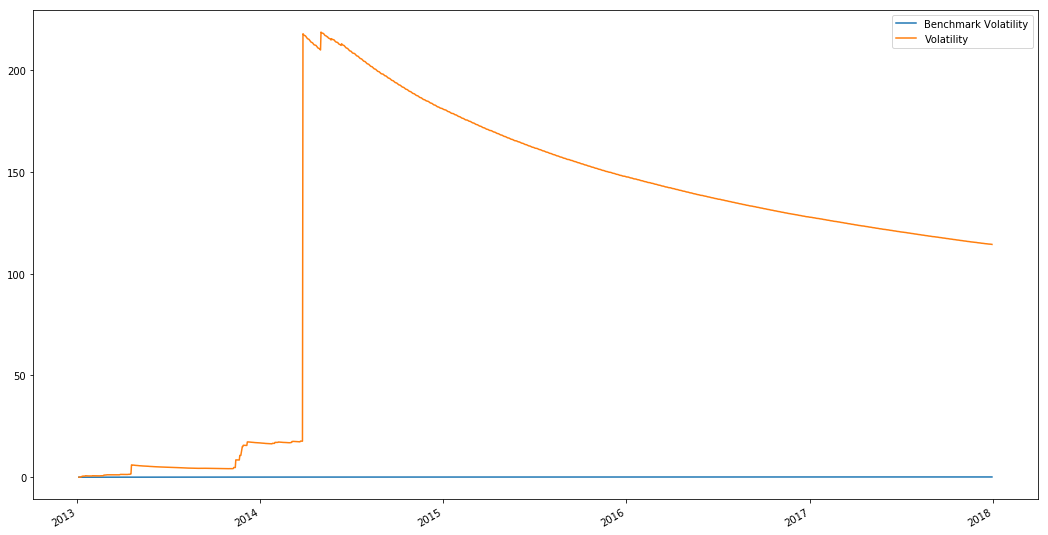

In [16]:
plt.figure(figsize=(18,10))
perf.benchmark_volatility.plot(label="Benchmark Volatility")
perf.algo_volatility.plot(label="Volatility")
plt.legend()